Выбор датасета
Был выбран датасет классификации львов и тигров. Данный датасет имеет широкое применения для иследованием за дикими животными.

Загрузка датасета

In [1]:
!curl -L -o qw.zip https://www.kaggle.com/api/v1/datasets/download/mikoajfish99/lions-or-cheetahs-image-classification
!unzip qw.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 71.3M  100 71.3M    0     0  41.9M      0  0:00:01  0:00:01 --:--:-- 72.7M
Archive:  qw.zip
  inflating: images/Cheetahs/0052cb267268c59e.jpg  
  inflating: images/Cheetahs/00707659aba29334.jpg  
  inflating: images/Cheetahs/007f9ffc01c7b106.jpg  
  inflating: images/Cheetahs/00bb45a8568a3474.jpg  
  inflating: images/Cheetahs/00c8d36882dd6d37.jpg  
  inflating: images/Cheetahs/00d100b0231b60e6.jpg  
  inflating: images/Cheetahs/00d9eb862ba3dfc6.jpg  
  inflating: images/Cheetahs/012f5ecbf49e1da0.jpg  
  inflating: images/Cheetahs/01750ba1a197e3ad.jpg  
  inflating: images/Cheetahs/01d688c043bdbfbb.jpg  
  inflating: images/Cheetahs/0230496e4a8ed917.jpg  
  inflating: images/Cheetahs/02871f24d5abe59c.jpg  
  inflating: images/Cheetahs/029b39c0b65ebe

Подготовка данных

In [2]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch

data_dir = 'images'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

Обучение встроенных моделей Resnet18(свверточная) и Vit(транформерная)

In [4]:
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 2)

vit = models.vit_b_16(pretrained=True)
vit.heads = torch.nn.Linear(vit.heads.head.in_features, 2)

resnet.to(device)
vit.to(device)

def train_model(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        loop = tqdm(loader, desc=f'Epoch {epoch+1}/{epochs}')
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f'Loss after epoch {epoch+1}: {running_loss / len(loader):.4f}')

def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_proba = [], [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_proba.extend(probs[:, 1].cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, f1


criterion = torch.nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet.parameters(), lr=1e-4)
optimizer_vit = torch.optim.Adam(vit.parameters(), lr=1e-5)

print("Обучение ResNet-18:")
train_model(resnet, train_loader, criterion, optimizer_resnet)
acc_rn, f1_rn = evaluate(resnet, val_loader)
print(f'ResNet: Accuracy={acc_rn:.3f}, F1={f1_rn:.3f}')

print("\nОбучение Vision Transformer:")
train_model(vit, train_loader, criterion, optimizer_vit)
acc_vit, f1_vit = evaluate(vit, val_loader)
print(f'ViT: Accuracy={acc_vit:.3f}, F1={f1_vit:.3f}')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weig

Обучение ResNet-18:


Epoch 1/5: 100%|██████████| 5/5 [00:43<00:00,  8.71s/it, loss=0.29]


Loss after epoch 1: 0.5344


Epoch 2/5: 100%|██████████| 5/5 [00:41<00:00,  8.35s/it, loss=0.0458]


Loss after epoch 2: 0.0877


Epoch 3/5: 100%|██████████| 5/5 [00:42<00:00,  8.46s/it, loss=0.00994]


Loss after epoch 3: 0.0230


Epoch 4/5: 100%|██████████| 5/5 [00:41<00:00,  8.31s/it, loss=0.00965]


Loss after epoch 4: 0.0149


Epoch 5/5: 100%|██████████| 5/5 [00:42<00:00,  8.54s/it, loss=0.00342]


Loss after epoch 5: 0.0087
ResNet: Accuracy=0.850, F1=0.875

Обучение Vision Transformer:


Epoch 1/5: 100%|██████████| 5/5 [05:16<00:00, 63.35s/it, loss=0.607]


Loss after epoch 1: 0.6957


Epoch 2/5: 100%|██████████| 5/5 [04:57<00:00, 59.47s/it, loss=0.389]


Loss after epoch 2: 0.4601


Epoch 3/5: 100%|██████████| 5/5 [04:52<00:00, 58.50s/it, loss=0.317]


Loss after epoch 3: 0.3175


Epoch 4/5: 100%|██████████| 5/5 [04:52<00:00, 58.52s/it, loss=0.145]


Loss after epoch 4: 0.2178


Epoch 5/5: 100%|██████████| 5/5 [04:52<00:00, 58.57s/it, loss=0.133]


Loss after epoch 5: 0.1441
ViT: Accuracy=0.875, F1=0.898


Улучшенный безлайн для ResNet

In [6]:
aug_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aug_dataset = datasets.ImageFolder(root=data_dir, transform=aug_transform)
aug_train, aug_val = random_split(aug_dataset, [train_size, val_size])
aug_train_loader = DataLoader(aug_train, batch_size=32, shuffle=True)
aug_val_loader = DataLoader(aug_val, batch_size=32)

resnet_aug = models.resnet18(pretrained=True)
resnet_aug.fc = torch.nn.Linear(resnet_aug.fc.in_features, 2)
resnet_aug.to(device)

optimizer = torch.optim.Adam(resnet_aug.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

print("\nОбучение ResNet с аугментациями:")
for epoch in range(5):
    resnet_aug.train()
    running_loss = 0.0
    loop = tqdm(aug_train_loader, desc=f'Epoch {epoch+1}/5')
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    avg_loss = running_loss / len(aug_train_loader)
    scheduler.step(avg_loss)
    print(f'Epoch {epoch+1} Loss: {avg_loss:.4f}')

acc_opt, f1_opt = evaluate(resnet_aug, aug_val_loader)
print(f'\nУлучшенный ResNet: Accuracy={acc_opt:.3f}, F1={f1_opt:.3f}')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Обучение ResNet с аугментациями:


Epoch 1/5: 100%|██████████| 5/5 [00:41<00:00,  8.23s/it, loss=0.484]


Epoch 1 Loss: 0.5995


Epoch 2/5: 100%|██████████| 5/5 [00:40<00:00,  8.19s/it, loss=0.299]


Epoch 2 Loss: 0.3384


Epoch 3/5: 100%|██████████| 5/5 [00:39<00:00,  7.97s/it, loss=0.333]


Epoch 3 Loss: 0.2224


Epoch 4/5: 100%|██████████| 5/5 [00:40<00:00,  8.04s/it, loss=0.165]


Epoch 4 Loss: 0.1676


Epoch 5/5: 100%|██████████| 5/5 [00:39<00:00,  7.99s/it, loss=0.0824]


Epoch 5 Loss: 0.1362

Улучшенный ResNet: Accuracy=0.825, F1=0.844


Улучшенный безлайн для Vit

In [11]:
transform_optimize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_optimize = datasets.ImageFolder(root="images", transform=transform_optimize)
train_data_optimize, val_data_optimize = random_split(dataset_optimize, [train_size, val_size])
train_loader_optimize = DataLoader(train_data_optimize, batch_size=32, shuffle=True)
val_loader_optimize = DataLoader(val_data_optimize, batch_size=32)

model_vit_optimized = models.vit_b_16(pretrained=True)
model_vit_optimized.heads = torch.nn.Linear(model_vit_optimized.heads.head.in_features, 2).to(device)

optimizer = torch.optim.Adam(model_vit_optimized.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

print("Обучение ViT с улучшенным бейзлайном:")
train_model(model_vit_optimized, train_loader_optimize, criterion, optimizer, device, epochs=5)
acc_vit_optimized, f1_vit_optimized = evaluate(model_vit_optimized, val_loader_optimize)
print(f"ViT Optimized: Accuracy={acc_vit_optimized:.3f}, F1={f1_vit_optimized:.3f}")

Обучение ViT с улучшенным бейзлайном:


Epoch 1/5: 100%|██████████| 5/5 [04:54<00:00, 58.99s/it, loss=0.604]


Epoch 1, Loss: 0.6666


Epoch 2/5: 100%|██████████| 5/5 [04:53<00:00, 58.65s/it, loss=0.431]


Epoch 2, Loss: 0.5102


Epoch 3/5: 100%|██████████| 5/5 [04:53<00:00, 58.62s/it, loss=0.404]


Epoch 3, Loss: 0.3895


Epoch 4/5: 100%|██████████| 5/5 [04:53<00:00, 58.74s/it, loss=0.227]


Epoch 4, Loss: 0.3054


Epoch 5/5: 100%|██████████| 5/5 [04:52<00:00, 58.46s/it, loss=0.134]


Epoch 5, Loss: 0.2201
ViT Optimized: Accuracy=0.900, F1=0.895


Собственная имплементация сверточной сети

In [13]:
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*54*54, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

custom_cnn = CustomCNN().to(device)
optimizer = torch.optim.Adam(custom_cnn.parameters(), lr=1e-3)

print("\nОбучение Custom CNN:")
train_model(custom_cnn, train_loader, criterion, optimizer, device, epochs=5)
acc_cnn, f1_cnn = evaluate(custom_cnn, val_loader)
print(f'Custom CNN: Accuracy={acc_cnn:.3f}, F1={f1_cnn:.3f}')


Обучение Custom CNN:


Epoch 1/5: 100%|██████████| 5/5 [00:23<00:00,  4.72s/it, loss=2.13]


Epoch 1, Loss: 8.5649


Epoch 2/5: 100%|██████████| 5/5 [00:24<00:00,  4.82s/it, loss=0.639]


Epoch 2, Loss: 1.4121


Epoch 3/5: 100%|██████████| 5/5 [00:23<00:00,  4.66s/it, loss=0.686]


Epoch 3, Loss: 0.6856


Epoch 4/5: 100%|██████████| 5/5 [00:21<00:00,  4.30s/it, loss=0.63]


Epoch 4, Loss: 0.6153


Epoch 5/5: 100%|██████████| 5/5 [00:20<00:00,  4.04s/it, loss=0.553]


Epoch 5, Loss: 0.5858
Custom CNN: Accuracy=0.725, F1=0.784


Улучшенный безлайн для собственной имплементации сверточной сети

In [14]:
custom_cnn_aug = CustomCNN().to(device)
optimizer = torch.optim.Adam(custom_cnn_aug.parameters(), lr=5e-4)

print("\nОбучение Custom CNN с аугментациями:")
train_model(custom_cnn_aug, aug_train_loader, criterion, optimizer, device, epochs=5)
acc, f1 = evaluate(custom_cnn_aug, aug_val_loader)
print(f'Custom CNN + Aug: Accuracy={acc:.3f}, F1={f1:.3f}')


Обучение Custom CNN с аугментациями:


Epoch 1/5: 100%|██████████| 5/5 [00:23<00:00,  4.72s/it, loss=4.01]


Epoch 1, Loss: 5.8637


Epoch 2/5: 100%|██████████| 5/5 [00:23<00:00,  4.68s/it, loss=1.43]


Epoch 2, Loss: 1.2103


Epoch 3/5: 100%|██████████| 5/5 [00:20<00:00,  4.05s/it, loss=0.668]


Epoch 3, Loss: 0.8430


Epoch 4/5: 100%|██████████| 5/5 [00:21<00:00,  4.26s/it, loss=0.676]


Epoch 4, Loss: 0.6843


Epoch 5/5: 100%|██████████| 5/5 [00:23<00:00,  4.69s/it, loss=0.713]


Epoch 5, Loss: 0.7261
Custom CNN + Aug: Accuracy=0.450, F1=0.476


Собственная имплементация Vit без и с улучшением безлайна

In [19]:
import torch
import torch.nn as nn

class CustomViT(nn.Module):
    def __init__(self, image_size=224, patch_size=16, num_classes=2,
                 dim=128, depth=4, heads=4, mlp_dim=256, dropout=0.1):
        super().__init__()
        assert image_size % patch_size == 0, "Image dimensions must be divisible by patch size."
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2

        self.patch_embedding = nn.Sequential(
            nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)

        self.transformer = nn.Transformer(
            d_model=dim,
            nhead=heads,
            num_encoder_layers=depth,
            dim_feedforward=mlp_dim,
            dropout=dropout,
            activation='gelu'
        )

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x).permute(0, 2, 1)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x, x)
        x = x[:, 0]
        return self.mlp_head(x)

my_vit = CustomViT(image_size=224, patch_size=16, num_classes=2).to(device)


optimizer = torch.optim.Adam(my_vit.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

print("Обучение собственной ViT:")
train_model(my_vit, train_loader, criterion, optimizer, device, epochs=5)
acc_my_vit, f1_my_vit = evaluate(my_vit, val_loader)
print(f"CustomViT: Accuracy={acc_my_vit:.3f}, F1={f1_my_vit:.3f}")

print("\nОбучение собственной ViT с улучшенным бейзлайном:")
train_model(my_vit, train_loader_optimize, criterion, optimizer, device, epochs=5)
acc_my_vit_optimized, f1_my_vit_optimized = evaluate(my_vit, val_loader_optimize)
print(f"CustomiT Optimized: Accuracy={acc_my_vit_optimized:.3f}, F1={f1_my_vit_optimized:.3f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Обучение собственной ViT:


Epoch 1/5: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it, loss=0.962]


Epoch 1, Loss: 1.2013


Epoch 2/5: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it, loss=0.665]


Epoch 2, Loss: 0.7091


Epoch 3/5: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it, loss=0.731]


Epoch 3, Loss: 0.7202


Epoch 4/5: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it, loss=0.685]


Epoch 4, Loss: 0.7222


Epoch 5/5: 100%|██████████| 5/5 [00:17<00:00,  3.55s/it, loss=0.729]


Epoch 5, Loss: 0.7079
CustomViT: Accuracy=0.575, F1=0.730

Обучение собственной ViT с улучшенным бейзлайном:


Epoch 1/5: 100%|██████████| 5/5 [00:19<00:00,  3.89s/it, loss=0.684]


Epoch 1, Loss: 0.6968


Epoch 2/5: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it, loss=0.683]


Epoch 2, Loss: 0.6992


Epoch 3/5: 100%|██████████| 5/5 [00:20<00:00,  4.18s/it, loss=0.703]


Epoch 3, Loss: 0.6953


Epoch 4/5: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it, loss=0.71]


Epoch 4, Loss: 0.6964


Epoch 5/5: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it, loss=0.735]


Epoch 5, Loss: 0.7058
CustomiT Optimized: Accuracy=0.500, F1=0.667


Проверим полученные модели на выполнение задачи классификаации

ResNet Predictions:


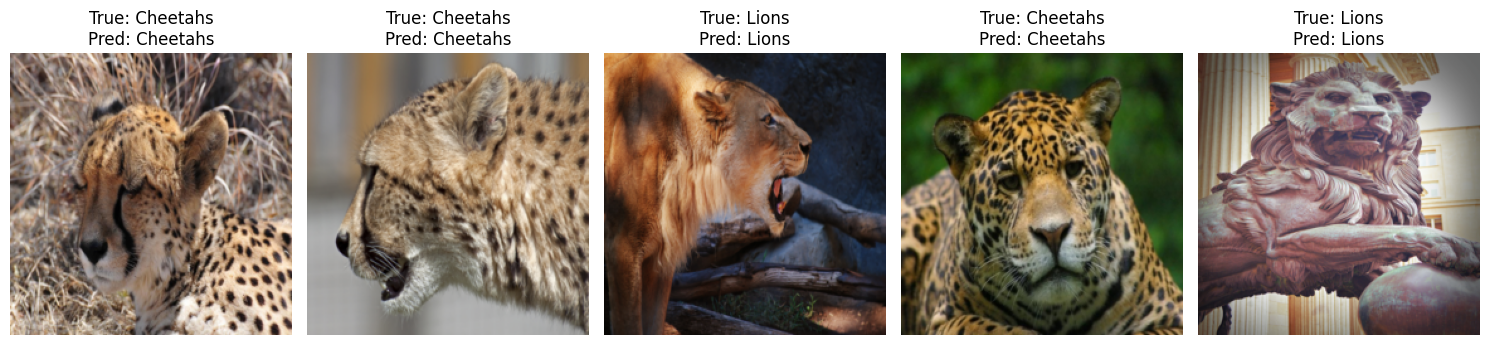

Vision Transformer Predictions:


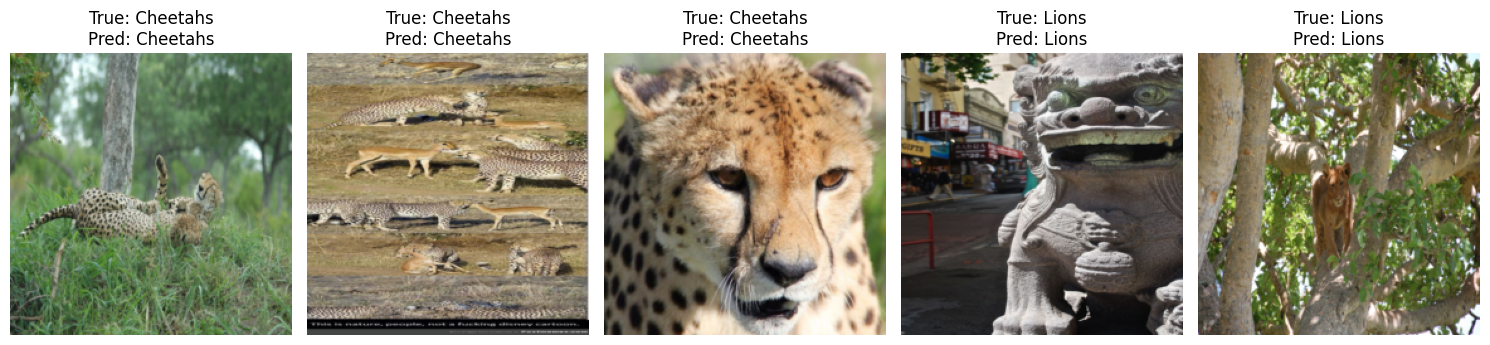

Improved ResNet Predictions:


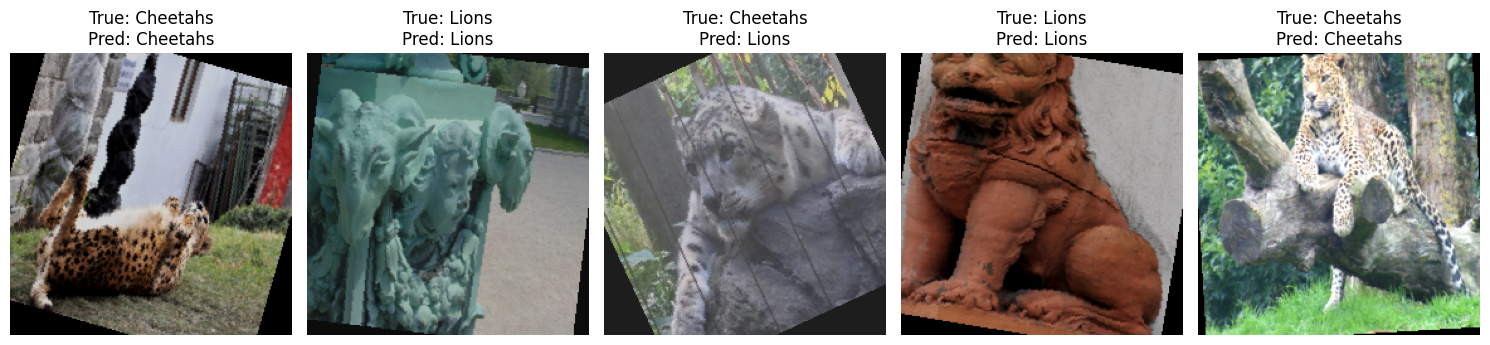

Improved ViT Predictions:


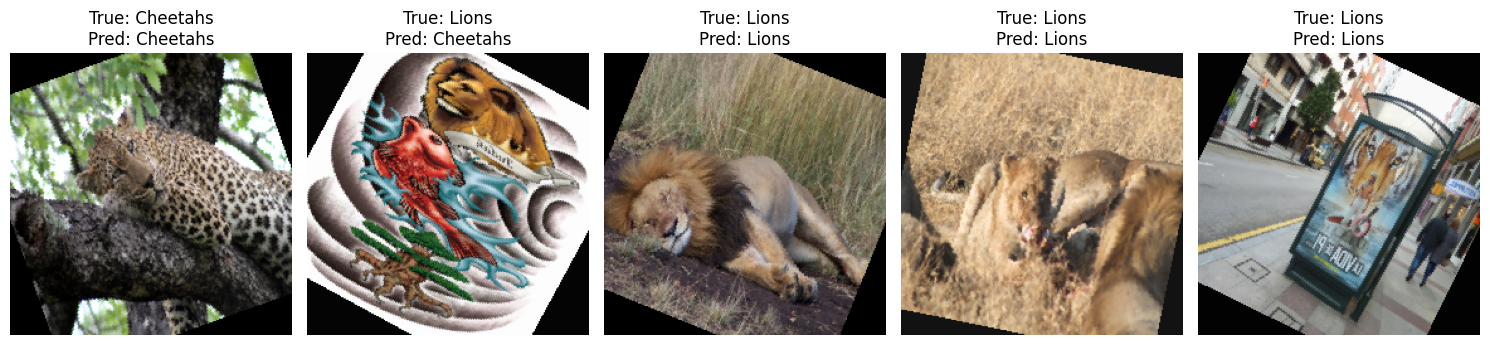

Custom CNN Predictions:


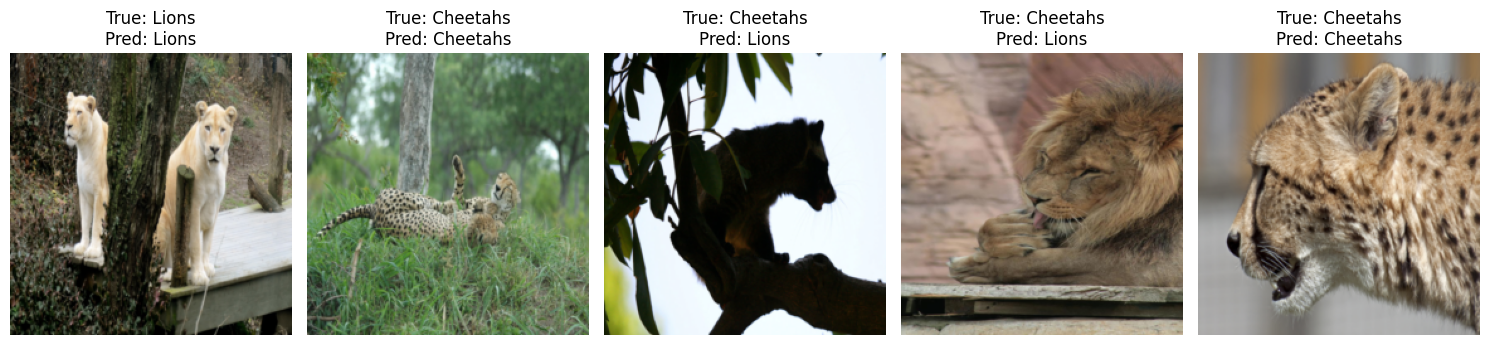

Custom CNN + Aug Predictions:


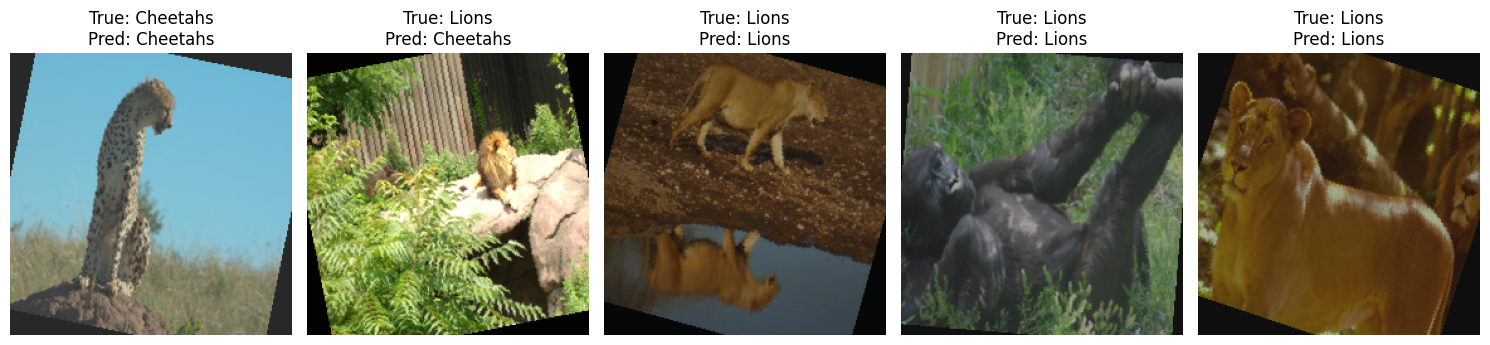

Custom ViT Predictions:


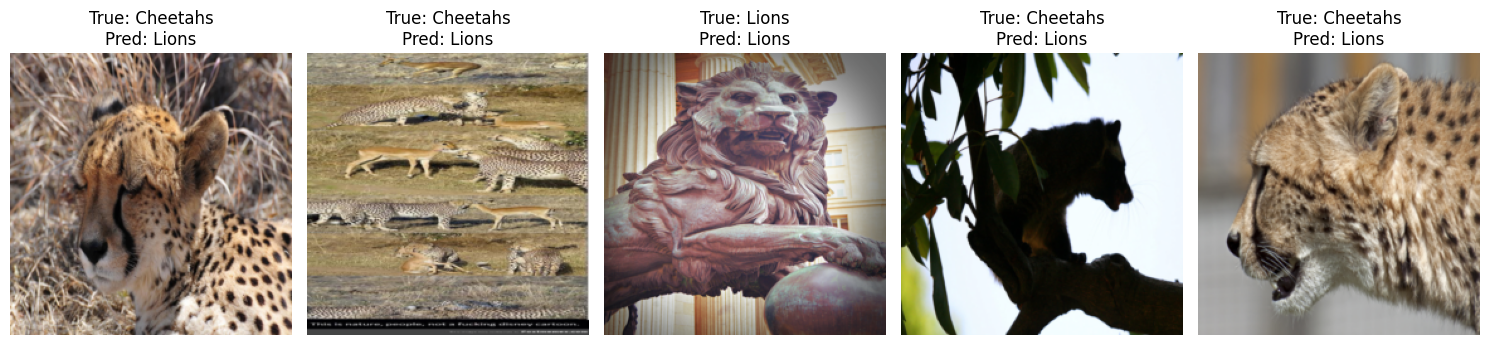

Custom ViT Optimized Predictions:


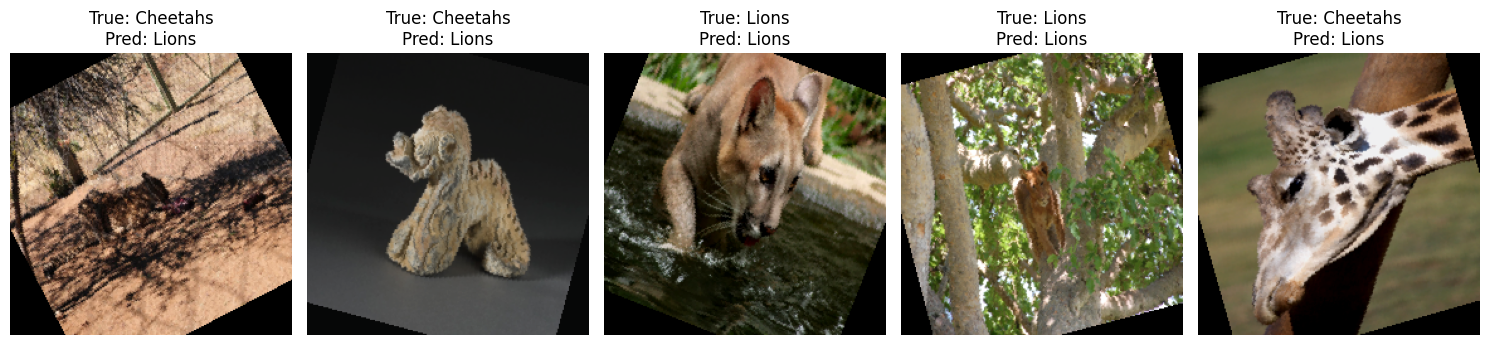

In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, dataset, num_images=5):
    model.eval()
    device = next(model.parameters()).device

    images, labels = next(iter(data_loader))
    indices = random.sample(range(len(images)), num_images)
    sample_images = images[indices]
    sample_labels = labels[indices]

    with torch.no_grad():
        outputs = model(sample_images.to(device))
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img = sample_images[i].permute(1, 2, 0).cpu().numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)

        true_label = dataset.classes[sample_labels[i]]
        pred_label = dataset.classes[preds[i]]

        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


print("ResNet Predictions:")
visualize_predictions(resnet, val_loader, dataset)

print("Vision Transformer Predictions:")
visualize_predictions(vit, val_loader, dataset)

print("Improved ResNet Predictions:")
visualize_predictions(resnet_aug, aug_val_loader, aug_dataset)

print("Improved ViT Predictions:")
visualize_predictions(model_vit_optimized, val_loader_optimize, dataset_optimize)

print("Custom CNN Predictions:")
visualize_predictions(custom_cnn, val_loader, dataset)

print("Custom CNN + Aug Predictions:")
visualize_predictions(custom_cnn_aug, aug_val_loader, aug_dataset)

print("Custom ViT Predictions:")
visualize_predictions(my_vit, val_loader, dataset)

print("Custom ViT Optimized Predictions:")
visualize_predictions(my_vit, val_loader_optimize, dataset_optimize)